In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)
n=10
for i in range(0,n):
  try:
    drive.mount('/content/drive', force_remount=True)
  except:
    pass

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
Mounted at /content/drive
Mounted at /content/drive
Mounted at /content/drive
Mounted at /content/drive
Mounted at /content/drive
Mounted at /content/drive
Mounted at /content/drive
Mounted at /content/drive
Mounted at /content/drive
Mounted at /content/drive


# Define the location for the data set and Glove for embedding


In [2]:
# The folder of the data set
dataset_path = '/content/drive/MyDrive/Graduation-Project/Phase 2/suicidal_detection'
# The folder for the models
model_path = '/content/drive/MyDrive/Graduation-Project/Phase 2/suicidal_detection/models'
# The folder where Glove is installed
TORCHNLP_CACHEDIR = f'{model_path}/Glove/pytorch-nlp_data'

# Define the Global Variables


In [3]:
isTrain = True
split_seed = 10
seed = 2
data_path = f"{dataset_path}/Suicide_Detection_Reddit.csv"

train_preprocess = f"{dataset_path}/train/dialogues_train_preprocess.pkl"

dev_preprocess = f"{dataset_path}/validation/dialogues_validation_preprocess.pkl"

test_preprocess = f"{dataset_path}/test/dialogues_test_preprocess.pkl"

model_save_path = f"{model_path}/model_20E_final.pt"

batch_size = 64

embedding_size = 300
lstm_hidden_size = 20
hidden_layer_size = 256
cnn_layer_size = 1
class_layer = 1

classification_threshold = 0.4

learning_rate = 0.1
epochs = 10
num_classes = 2

momentum = 0.09

# Imports


In [4]:
!pip install pytorch-nlp --quiet
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --quiet
!pip install scikit-learn --quiet
!pip install pyspellchecker --quiet
!pip install contractions --quiet
!pip install beautifulsoup4 --quiet
!pip install emoji --quiet
!pip install matplotlib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 99.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [5]:
from typing import List, Tuple, Callable, Dict
import random
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import torch.autograd
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, classification_report, confusion_matrix, precision_recall_curve)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torchnlp.word_to_vector import GloVe
import contractions
import unicodedata
from bs4 import BeautifulSoup
import emoji
import re
from spellchecker import SpellChecker
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [6]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [7]:

# define Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define Glove
pretrained_wv = GloVe(cache=TORCHNLP_CACHEDIR)
# Stopword removal
stop_words = set(stopwords.words('english'))
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

In [8]:
print(DEVICE)

cuda


# Helper functions


In [9]:
def dump_tuple(filename: str, data: tuple) -> None:
    '''
    Dump the tuple to a file.
    :param filename: The name of the file to dump the tuple to.
    :type filename: str
    :param data: The tuple to dump.
    :type data: tuple
    '''
    with open(filename, 'wb') as file:
        pickle.dump(data, file)


def load_tuple(filename: str) -> tuple:
    '''
    Load the tuple from the file.
    :param filename: The name of the file to load the tuple from.
    :type filename: str
    :return: The loaded tuple.
    :rtype: tuple
    '''
    with open(filename, 'rb') as file:
        return pickle.load(file)


def dump_var(filename: str, data: List[List[torch.Tensor]]) -> None:
    '''
    Dump the data to a file.
    :param filename: The name of the file to dump the data to.
    :type filename: str
    :param data: The data dump.
    '''
    torch.save(data, filename)


def load_var(filename: str) -> List[List[torch.Tensor]]:
    '''
    Load the data from the file.
    :param filename: The name of the file to load the data from.
    :type filename: str
    :return: The loaded data.
    :rtype: Any
    '''
    return torch.load(filename)

# Preparing the Data set


In [10]:
def lower_sentence(sentence: str) -> str:
    '''
    Lowercase the sentence.
    :param data: The sentence to lowercase.
    :return: The lowercased sentence
    :rtype: str
    '''
    return sentence.lower()

In [11]:
def remove_emails(sentence: str) -> str:
    '''
    Remove emails from the sentence.
    :param sentence: The sentence to remove emails from.
    :type sentence: str
    :return: The sentence without emails.
    :rtype: str
    '''
    return re.sub(r"\S*@\S*\s?", "", sentence)

In [12]:
def remove_nonascii_diacritic(sentence: str) -> str:
    '''

    Remove diacritics from the sentence.

    :param sentence: The sentence to remove diacritics from.

    :type sentence: str

    :return: The sentence without diacritics.

    :rtype: str
    '''

    return unicodedata.normalize("NFKD", sentence).encode("ascii", "ignore").decode("utf-8", "ignore")

In [13]:
def clean_html(sentence: str) -> str:
    '''
    Remove HTML tags from the sentence.
    :param sentence: The sentence to remove HTML tags from.
    :type sentence: str
    :return: The sentence without HTML tags.
    :rtype: str
    '''
    return BeautifulSoup(sentence, "html.parser").get_text()

In [14]:
def replace_repeated_chars(sentence: str) -> str:
    '''
    Replace repeated characters in the sentence.
    :param sentence: The sentence to replace repeated characters in.
    :type sentence: str
    :return: The sentence with replaced repeated characters.
    :rtype: str
    '''
    # Replace consecutive occurrences of ',', '!', '.', and '?' with a single occurrence
    return re.sub(r'([,!?.])\1+', r'\1', sentence)

In [15]:
def translate_emojis_to_text(sentence: str) -> str:
    '''
    Translate emojis in the sentence to text.
    :param sentence: The sentence to translate emojis to text.
    :type sentence: str
    :return: The sentence with translated emojis to text.
    :rtype: str
    '''
    # Translate emojis to text codes
    translated_text = emoji.demojize(sentence)
    # Remove colons from the translated text
    translated_text = re.sub(r':', '', translated_text)
    return translated_text

In [16]:
def expand_sentence(sentence: str) -> str:
    '''
    Expand the contractions in the sentence.
    :param sentence: The sentence to expand contractions in.
    :type sentence: str
    :return: The sentence with expanded contractions.
    :rtype: str
    '''
    return contractions.fix(sentence)

In [17]:
def remove_url(sentence: str) -> str:
    '''
    Remove URLs from the sentence.
    :param sentence: The sentence to remove URLs from.
    :type sentence: str
    :return: The sentence without URLs.
    :rtype: str
    '''
    return re.sub("((http\://|https\://|ftp\://)|(www.))+(([a-zA-Z0-9\.-]+\.[a-zA-Z]{2,4})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(/[a-zA-Z0-9%:/-_\?\.'~]*)?", '', sentence)

In [18]:
def remove_possessives(sentence: str) -> str:
    '''
    Strip possessives from the sentence.
    :param sentence: The sentence to strip possessives from.
    :type sentence: str
    :return: The sentence without possessives.
    :rtype: str
    '''
    # Stripping the possessives
    sentence = sentence.replace("'s", '')
    sentence = sentence.replace('’s', '')
    sentence = sentence.replace('s’', 's')
    sentence = sentence.replace("s'", 's')
    return sentence

In [19]:
def remove_extra_space(sentence: str) -> str:
    '''
    Remove extra spaces from the sentence.
    :param sentence: The sentence to remove extra spaces from.
    :type sentence: str
    :return: The sentence without extra spaces.
    :rtype: str
    '''
    return re.sub(r'\s+', ' ', sentence).strip()

In [20]:
def check_sentence_spelling(sentence: list[str]) -> list[str]:
    '''
    Check the spelling of the words in the sentence.
    :param sentence: The sentence to check the spelling of.
    :type sentence: list
    :return: The sentence with corrected spelling.
    :rtype: list
    '''
    spell = SpellChecker()
    corrected_sentence = []
    for word in sentence:
        if word != '':
            correction = spell.correction(word)
            if correction is not None:
                corrected_sentence.append(correction)
            else:
                corrected_sentence.append(word)
        else:
            corrected_sentence.append('')
    return corrected_sentence

In [21]:
def tokenize_sentence(sentence: str) -> list[str]:
    '''
    Tokenize the sentence.
    :param sentence: The sentence to tokenize.
    :type sentence: str
    :return: The tokenized sentence.
    :rtype: str
    '''
    return nltk.word_tokenize(sentence)

In [22]:
def remove_stop_words(sentence: list[str]) -> list[str]:
    '''
    Remove stop words from the sentence.
    :param sentence: The sentence to remove stop words from.
    :type sentence: list[str]
    :return: The sentence without stop words.
    :rtype: list[str]
    '''
    return [word for word in sentence if word not in stop_words]

In [23]:
def lemm_sentence(sentence: list[str]) -> list[str]:
    '''
    Lemmatize the sentence.
    :param sentence: The sentence to lemmatize.
    :type sentence: list[str]
    :return: The lemmatized sentence.
    :rtype: list[str]
    '''
    # Perform POS tagging
    pos_tags = pos_tag(sentence)
    # Lemmatize each word based on its POS tag
    lemmatized_words = []
    for word, pos in pos_tags:
        # Map Penn Treebank POS tags to WordNet POS tags
        if pos.startswith('N'):  # Nouns
            pos = 'n'
        elif pos.startswith('V'):  # Verbs
            pos = 'v'
        elif pos.startswith('J'):  # Adjectives
            pos = 'a'
        elif pos.startswith('R'):  # Adverbs
            pos = 'r'
        else:
            pos = 'n'  # Default to noun if POS tag not found

        # Lemmatize the word using the appropriate POS tag
        lemma = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_words.append(lemma)
    return lemmatized_words

In [24]:
def clean_train(line: str) -> list[str]:
    '''
    Clean the line and return it as a list of tokens
    :param line: the line to clean
    :type line: str
    :return: the cleaned line as a list of tokens
    :rtype: list
    '''
    # translate emojis
    line = translate_emojis_to_text(line)
    # lower the line
    line = lower_sentence(line)
    # remove non ascii
    line = remove_nonascii_diacritic(line)
    # remove emails
    line = remove_emails(line)
    # remove html
    line = clean_html(line)
    # remove urls
    line = remove_url(line)
    # replace repeated chars
    line = replace_repeated_chars(line)
    # expand
    line = expand_sentence(line)
    # remove possessives
    line = remove_possessives(line)
    # remove extra spaces
    line = remove_extra_space(line)
    # tekonize
    line = tokenize_sentence(line)
    # remove stopwords
    # line = remove_stop_words(line)
    # lemmetization
    # line = lemm_sentence(line)
    if len(line) == 0:
        return ['Normal']
    return line

In [25]:
def clean_steps(line: str) -> list[str]:
    '''
    Clean the line and return it as a list of tokens
    :param line: the line to clean
    :type line: str
    :return: the cleaned line as a list of tokens
    :rtype: list
    '''
    print('-------------------------------')
    # translate emojis
    line = translate_emojis_to_text(line)
    print("After translate --> ", line)
    # lower the line
    line = lower_sentence(line)
    print("After lower --> ", line)
    # remove non ascii
    line = remove_nonascii_diacritic(line)
    print("After remoeve non ascii --> ", line)
    line = remove_emails(line)
    print("After remove email --> ", line)
    # remove html
    line = clean_html(line)
    print("After remove html --> ", line)
    # remove urls
    line = remove_url(line)
    print("After remove url --> ", line)
    # replace repeated chars
    line = replace_repeated_chars(line)
    print("replace repeated chars --> ", line)
    # expand
    line = expand_sentence(line)
    print("After expand --> ", line)
    # remove possessives
    line = remove_possessives(line)
    print("After remove possessives --> ", line)
    # remove extra spaces
    line = remove_extra_space(line)
    print("After remove extra space --> ", line)
    # tekonize
    line = tokenize_sentence(line)
    print("After tokenize --> ", line)
    # check spelling
    line = check_sentence_spelling(line)
    print("After spelling check --> ", line)
    # remove stopwords
    # line = remove_stop_words(line)
    # print("After remove stop words --> ", line)
    # lemmetization
    # line = lemm_sentence(line)
    # print("After lemmatization --> ", line)
    print('-------------------------------')
    if len(line) == 0:
        print(['Normal'])
        return ['Normal']
    return line

In [26]:
def clean(line: str) -> list[str]:
    '''
    Clean the line and return it as a list of tokens
    :param line: the line to clean
    :type line: str
    :return: the cleaned line as a list of tokens
    :rtype: list
    '''
    # translate emojis
    line = translate_emojis_to_text(line)
    # lower the line
    line = lower_sentence(line)
    # remove non ascii
    line = remove_nonascii_diacritic(line)
    # remove emails
    line = remove_emails(line)
    # remove html
    line = clean_html(line)
    # remove urls
    line = remove_url(line)
    # replace repeated chars
    line = replace_repeated_chars(line)
    # expand
    line = expand_sentence(line)
    # remove possessives
    line = remove_possessives(line)
    # remove extra spaces
    line = remove_extra_space(line)
    # tekonize
    line = tokenize_sentence(line)
    # check spelling
    line = check_sentence_spelling(line)
    # remove stopwords
    # line = remove_stop_words(line)
    # lemmetization
    # line = lemm_sentence(line)
    if len(line) == 0:
        return ['Normal']
    return line

In [27]:
# define the mapping from 's' to 1 and 'u' to 0
forward_label_mapping = {'suicide': 1, 'non-suicide': 0}

# define the reverse mapping from 0 to 'u' and 1 to 's'
reverse_label_mapping = {0: 'non-suicide', 1: 'suicide'}

In [28]:
# Read CSV file into DataFrame
df = pd.read_csv(data_path)
# Count unique values in each column
unique_counts = df.nunique()
# Display the count of unique values
print('Number of Unique Values:')
print(unique_counts)
# print the unique values of emotion
print('unique target classes', df['class'].unique())
# get the number of dialogue
num_Dialogues = len(df['class'])
# print the number of dialogues
print('Number of Dialogues: ', num_Dialogues)
print('First 5 elements: ')
print(df.head())

Number of Unique Values:
Unnamed: 0    232074
text          232074
class              2
dtype: int64
unique target classes ['suicide' 'non-suicide']
Number of Dialogues:  232074
First 5 elements: 
   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide


In [29]:
print("Check for missing values in the dataset")
null_check = df.isnull().sum()
print(null_check)

Check for missing values in the dataset
Unnamed: 0    0
text          0
class         0
dtype: int64


In [30]:
# Check for duplicate rows in the entire DataFrame
duplicate_rows = df.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicate_rows.sum()

# Display the duplicate rows
duplicate_data = df[duplicate_rows]

print(f"Number of duplicate rows: {num_duplicates}")
print("Duplicate rows:")
print(duplicate_data)

Number of duplicate rows: 0
Duplicate rows:
Empty DataFrame
Columns: [Unnamed: 0, text, class]
Index: []


class
suicide        116037
non-suicide    116037
Name: count, dtype: int64


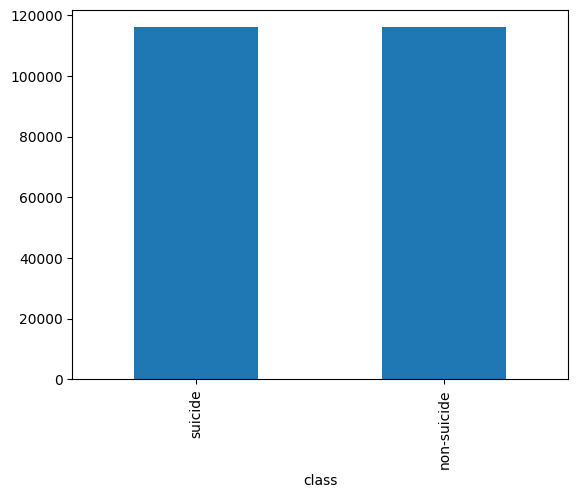

In [31]:
if isTrain:
    # check the distrubution of the data
    # check how many suicidal and how many non-suicidal
    print(df['class'].value_counts())
    # plot a graph
    df['class'].value_counts().plot(kind='bar')

In [32]:
def read_dataset_suicidal_detection(data_path: str, split_seed: int) -> Tuple[Tuple[List[str], List[int]], Tuple[List[str], List[int]], Tuple[List[str], List[int]]]:
    '''
    Read the dataset for the suicidal detection task.
    :param data_path: The path to the dataset.
    :type data_path: str
    :param split_seed: The seed to use for splitting the dataset.
    :type split_seed: int
    :return: The training, validation, and test sets.
    :rtype: Tuple[Tuple[List[str], List[int]], Tuple[List[str], List[int]], Tuple[List[str], List[int]]]
    '''
    data = pd.read_csv(data_path)
    # extract the dialogues and their corresponding labels
    dialogues = data['text'].tolist()
    labels = data['class'].apply(lambda x: forward_label_mapping[x]).tolist()

    # split the data into training and temporary sets (70% training, 30% temporary)
    dialogues_train, dialogues_temp, labels_train, labels_temp = train_test_split(
        dialogues, labels, test_size=0.3, random_state=split_seed)

    # split the temporary set into validation and test sets (66.67% validation, 33.33% test)
    dialogues_val, dialogues_test, labels_val, labels_test = train_test_split(
        dialogues_temp, labels_temp, test_size=0.33, random_state=split_seed)

    return (dialogues_train, labels_train), (dialogues_val, labels_val), (dialogues_test, labels_test)

In [33]:
# read the data set
(dialogues_train, labels_train), (dialogues_val, labels_val), (dialogues_test,
                                                               labels_test) = read_dataset_suicidal_detection(data_path, split_seed)
# print the number of dialogues in each set and percentage of total data
print(
    f"Number of dialogues in training set: {len(dialogues_train)} ({len(dialogues_train) / num_Dialogues:.2f}%)")
print(
    f"Number of dialogues in validation set: {len(dialogues_val)} ({len(dialogues_val) / num_Dialogues:.2f}%)")
print(
    f"Number of dialogues in test set: {len(dialogues_test)} ({len(dialogues_test) / num_Dialogues:.2f}%)")

Number of dialogues in training set: 162451 (0.70%)
Number of dialogues in validation set: 46647 (0.20%)
Number of dialogues in test set: 22976 (0.10%)


In [34]:
# plot the percentage of each class in each set
def plot_class_distribution(labels: List[int], title: str) -> None:
    '''
    Plot the class distribution.
    :param labels: The labels of the dialogues.
    :type labels: List[int]
    :param title: The title of the plot.
    :type title: str
    '''
    # Count the number of dialogues in each class
    class_counts = np.bincount(labels)
    # Define the class labels
    class_labels = [reverse_label_mapping[label]
                    for label in range(len(class_counts))]
    # Plot the class distribution
    plt.figure()

    plt.bar(class_labels, class_counts, color=['skyblue', 'cyan'])
    plt.xlabel('Class')
    plt.ylabel('Number of Dialogues')
    plt.title(title)
    plt.show()

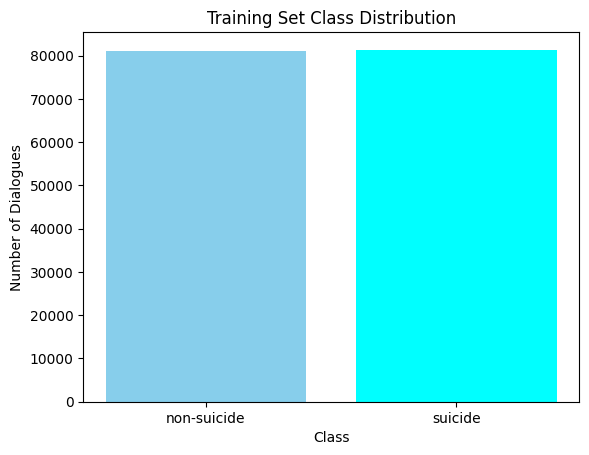

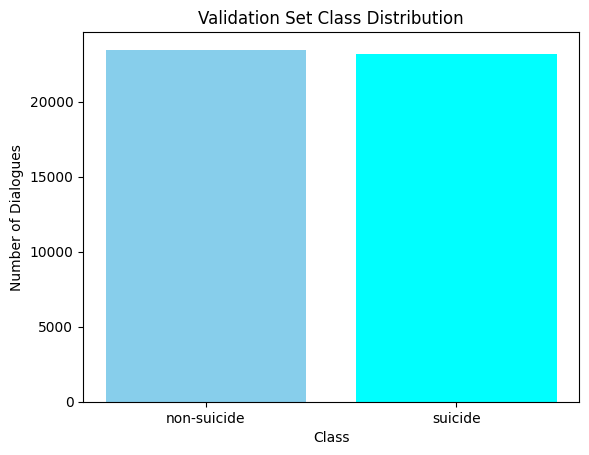

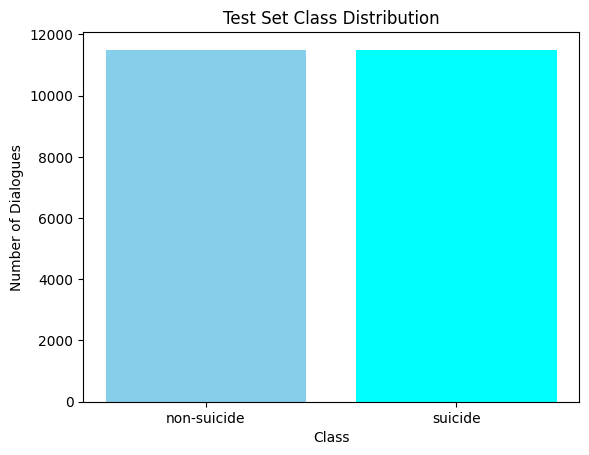

In [35]:
if isTrain:
    plot_class_distribution(labels_train, 'Training Set Class Distribution')
    plot_class_distribution(labels_val, 'Validation Set Class Distribution')
    plot_class_distribution(labels_test, 'Test Set Class Distribution')

In [36]:
if isTrain:
    # print example from each set
    print('Example from training set:')
    print('-------------------------------------')
    print(dialogues_train[0])
    print(f'prediction: {labels_train[0]}')
    print('-------------------------------------')
    print('Example from validation set:')
    print('-------------------------------------')
    print(dialogues_val[0])
    print(f'prediction: {labels_val[0]}')
    print('-------------------------------------')
    print('Example from test set:')
    print('-------------------------------------')
    print(dialogues_test[0])
    print(f'prediction: {labels_test[0]}')
    print('-------------------------------------')

Example from training set:
-------------------------------------
i’m so stupid i’m so fucking dumb dude. i literally thought las vegas was new vegas for 7 years until now. i’m gonna die
prediction: 0
-------------------------------------
Example from validation set:
-------------------------------------
No hope, but don't want to hurt my familyMy desire to die is, to me, pretty rational. I have nothing to contribute to the world don't anticipate being able to enjoy life for myself at any time in the future. There are only 4 people in the world who would be noticeably saddened at my passing, and I'm certain 3 of them would be tangibly better off without me, but they all want me to stick around.

When I say I'm not worth the space I take up, it's not a passing moment of angst. I have no particular practical skills, and zero social skills. I can hold down a "warm body" job, but don't have any abilities or passions that would translate into a job that paid enough that I'd be financially st

In [37]:
def clean_data(data: List[str]) -> List[List[str]]:
    '''
    Clean the data.
    :param data: The data to clean.
    :type data: List[str]
    :return: The cleaned data.
    :rtype: List[List[str]]
    '''
    cleaned_data = []
    for line in tqdm(data):
        cleaned_line = clean_train(line)
        cleaned_data.append(cleaned_line)
    return cleaned_data

In [38]:

if isTrain:
    # test clean data
    cleaned_train = clean_data(dialogues_val[0:2])
    print('Example from cleaned val set:')
    print(cleaned_train[0])

    # test clean data
    cleaned_train = clean_steps(dialogues_val[0:2])
    print('Example from cleaned val set:')
    print(cleaned_train[0])

100%|██████████| 2/2 [00:00<00:00, 54.85it/s]

Example from cleaned val set:
['no', 'hope', ',', 'but', 'do', 'not', 'want', 'to', 'hurt', 'my', 'familymy', 'desire', 'to', 'die', 'is', ',', 'to', 'me', ',', 'pretty', 'rational', '.', 'i', 'have', 'nothing', 'to', 'contribute', 'to', 'the', 'world', 'do', 'not', 'anticipate', 'being', 'able', 'to', 'enjoy', 'life', 'for', 'myself', 'at', 'any', 'time', 'in', 'the', 'future', '.', 'there', 'are', 'only', '4', 'people', 'in', 'the', 'world', 'who', 'would', 'be', 'noticeably', 'saddened', 'at', 'my', 'passing', ',', 'and', 'i', 'am', 'certain', '3', 'of', 'them', 'would', 'be', 'tangibly', 'better', 'off', 'without', 'me', ',', 'but', 'they', 'all', 'want', 'me', 'to', 'stick', 'around', '.', 'when', 'i', 'say', 'i', 'am', 'not', 'worth', 'the', 'space', 'i', 'take', 'up', ',', 'it', 'is', 'not', 'a', 'passing', 'moment', 'of', 'angst', '.', 'i', 'have', 'no', 'particular', 'practical', 'skills', ',', 'and', 'zero', 'social', 'skills', '.', 'i', 'can', 'hold', 'down', 'a', '``', 'war

After spelling check -->  ['no', 'hope', ',', 'but', 'do', 'not', 'want', 'to', 'hurt', 'my', 'family', 'desire', 'to', 'die', 'is', ',', 'to', 'me', ',', 'pretty', 'rational', '.', 'i', 'have', 'nothing', 'to', 'contribute', 'to', 'the', 'world', 'do', 'not', 'anticipate', 'being', 'able', 'to', 'enjoy', 'life', 'for', 'myself', 'at', 'any', 'time', 'in', 'the', 'future', '.', 'there', 'are', 'only', '4', 'people', 'in', 'the', 'world', 'who', 'would', 'be', 'noticeably', 'saddened', 'at', 'my', 'passing', ',', 'and', 'i', 'am', 'certain', '3', 'of', 'them', 'would', 'be', 'tangibly', 'better', 'off', 'without', 'me', ',', 'but', 'they', 'all', 'want', 'me', 'to', 'stick', 'around', '.', 'when', 'i', 'say', 'i', 'am', 'not', 'worth', 'the', 'space', 'i', 'take', 'up', ',', 'it', 'is', 'not', 'a', 'passing', 'moment', 'of', 'angst', '.', 'i', 'have', 'no', 'particular', 'practical', 'skills', ',', 'and', 'zero', 'social', 'skills', '.', 'i', 'can', 'hold', 'down', 'a', 'i', 'warm', 'bo

# preprocess the data set (Train, Validation, Test) if not preprocessed


In [46]:
!ls '/content/drive/MyDrive/Graduation-Project/Phase 2/suicidal_detection/train'

In [40]:
if isTrain:
    if not os.path.exists(train_preprocess):
        print("Preprocessing the training data")
        dialogues_train_proccessed = clean_data(dialogues_train)
        dump_tuple(train_preprocess,
                   (dialogues_train_proccessed, labels_train))
    else:
        print("The preprocessed train data already exists")

Preprocessing the training data


  0%|          | 0/162451 [00:00<?, ?it/s]<ipython-input-13-2d1d7d07ee10>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(sentence, "html.parser").get_text()
100%|██████████| 162451/162451 [08:28<00:00, 319.78it/s]


In [41]:
if isTrain:
    if not os.path.exists(dev_preprocess):
        print("Preprocessing the validation data")
        dialogues_val_proccessed = clean_data(dialogues_val)
        dump_tuple(dev_preprocess, (dialogues_val_proccessed, labels_val))
    else:
        print("The preprocessed dev data already exists")

Preprocessing the validation data


  0%|          | 39/46647 [00:00<02:02, 381.88it/s]<ipython-input-13-2d1d7d07ee10>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(sentence, "html.parser").get_text()
100%|██████████| 46647/46647 [02:47<00:00, 278.99it/s]


In [42]:
if not os.path.exists(test_preprocess):
    print("Preprocessing the testing data")
    dialogues_test_proccessed = clean_data(dialogues_test)
    dump_tuple(test_preprocess, (dialogues_test_proccessed, labels_test))
else:
    print("The preprocessed test data already exists")

Preprocessing the testing data


  0%|          | 0/22976 [00:00<?, ?it/s]<ipython-input-13-2d1d7d07ee10>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(sentence, "html.parser").get_text()
100%|██████████| 22976/22976 [01:54<00:00, 201.44it/s]


# load the data (train, val, test)


In [45]:
if isTrain:
    # load data (train, dev, test)
    dialogues_train_proccessed, labels_train = load_tuple(train_preprocess)
    dialogues_val_proccessed, labels_val = load_tuple(dev_preprocess)
dialogues_test_proccessed, labels_test = load_tuple(test_preprocess)
if isTrain:
    # print length of each
    print("train data length: ", len(
        dialogues_train_proccessed), len(labels_train))
    print("dev data length: ", len(dialogues_val_proccessed), len(labels_val))
print("test data length: ", len(dialogues_test_proccessed), len(labels_test))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Graduation-Project/Phase 2/suicidal_detection/train/dialogues_train_preprocess.pkl'

# define the dataset


In [44]:
def glove(word: str) -> torch.Tensor:
    """
    Retrieves the word embedding vector for a given word.

    :param word: The word for which the embedding vector is retrieved.
    :type word: str
    :return: The word embedding vector for the given word.
    :rtype: torch.Tensor
    """
    return pretrained_wv[word]

In [47]:
if isTrain:
    # test glove
    embedding_test = glove('hello')
    print(embedding_test)
    print(len(embedding_test))

tensor([ 0.2523,  0.1018, -0.6748,  0.2112,  0.4349,  0.1654,  0.4826, -0.8122,
         0.0413,  0.7850, -0.0779, -0.6632,  0.1464, -0.2929, -0.2549,  0.0193,
        -0.2026,  0.9823,  0.0283, -0.0813, -0.1214,  0.1313, -0.1765,  0.1356,
        -0.1636, -0.2257,  0.0550, -0.2031,  0.2072,  0.0958,  0.2248,  0.2154,
        -0.3298, -0.1224, -0.4003, -0.0794, -0.1996, -0.0151, -0.0791, -0.1813,
         0.2068, -0.3620, -0.3074, -0.2442, -0.2311,  0.0980,  0.1463, -0.0627,
         0.4293, -0.0780, -0.1963,  0.6509, -0.2281, -0.3031, -0.1248, -0.1757,
        -0.1465,  0.1536, -0.2952,  0.1510, -0.5173, -0.0336, -0.2311, -0.7833,
         0.0180, -0.1572,  0.0229,  0.4964,  0.0292,  0.0567,  0.1462, -0.1919,
         0.1624,  0.2390,  0.3643,  0.4526,  0.2456,  0.2380,  0.3140,  0.3487,
        -0.0358,  0.5611, -0.2535,  0.0520, -0.1062, -0.3096,  1.0585, -0.4202,
         0.1822, -0.1126,  0.4058,  0.1178, -0.1971, -0.0753,  0.0807, -0.0278,
        -0.1562, -0.4468, -0.1516,  0.16

# Define Dataest


In [48]:
class SUIDataset(Dataset):
    def __init__(self, inputs: list, targets: list, word2vec: Callable[[str], torch.Tensor]):
        '''
        Initialize the EDCDataset.

        :param inputs: List of conversations, where each conversation is a list of sentences,
                       and each sentence is a list of words.
        :type inputs: list
        :param targets: List of labels for each conversation.
        :type targets: list
        '''
        self.inputs = inputs
        self.targets = targets
        self.word2vec = word2vec

    def __getitem__(self, index: int) -> tuple:
        '''
        Get the item at the specified index.

        :param index: The index of the item to get.
        :type index: int
        :return: The conversation and its label at the specified index.
        :rtype: tuple
        '''
        return [self.word2vec(word) for word in self.inputs[index]], self.targets[index]

    def __len__(self) -> int:
        '''
        Get the length of the dataset.

        :return: The number of samples in the dataset.
        :rtype: int
        '''
        return len(self.inputs)

In [49]:
if isTrain:
    # test
    conversations = [
        [
            'hello',
            'tired'
        ],
        [
            'sad',
            'ill'
        ]
    ]

    labels = [
        0,
        1
    ]

    dataset = SUIDataset(conversations, labels, glove)

    inputs, target = dataset[0]

    print("Inputs:", inputs)
    print("Target:", target)

Inputs: [tensor([ 0.2523,  0.1018, -0.6748,  0.2112,  0.4349,  0.1654,  0.4826, -0.8122,
         0.0413,  0.7850, -0.0779, -0.6632,  0.1464, -0.2929, -0.2549,  0.0193,
        -0.2026,  0.9823,  0.0283, -0.0813, -0.1214,  0.1313, -0.1765,  0.1356,
        -0.1636, -0.2257,  0.0550, -0.2031,  0.2072,  0.0958,  0.2248,  0.2154,
        -0.3298, -0.1224, -0.4003, -0.0794, -0.1996, -0.0151, -0.0791, -0.1813,
         0.2068, -0.3620, -0.3074, -0.2442, -0.2311,  0.0980,  0.1463, -0.0627,
         0.4293, -0.0780, -0.1963,  0.6509, -0.2281, -0.3031, -0.1248, -0.1757,
        -0.1465,  0.1536, -0.2952,  0.1510, -0.5173, -0.0336, -0.2311, -0.7833,
         0.0180, -0.1572,  0.0229,  0.4964,  0.0292,  0.0567,  0.1462, -0.1919,
         0.1624,  0.2390,  0.3643,  0.4526,  0.2456,  0.2380,  0.3140,  0.3487,
        -0.0358,  0.5611, -0.2535,  0.0520, -0.1062, -0.3096,  1.0585, -0.4202,
         0.1822, -0.1126,  0.4058,  0.1178, -0.1971, -0.0753,  0.0807, -0.0278,
        -0.1562, -0.4468, -0.15

In [50]:
def collate_fn(batch: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor]:
    '''
    Collate function to be used with DataLoader.
    :param batch: The batch to collate.
    :type batch: List[Tuple[torch.Tensor, torch.Tensor]]
    :return: The padded inputs and targets.
    :rtype: Tuple[torch.Tensor, torch.Tensor]
    '''
    # Unzip the batch
    inputs, targets = zip(*batch)

    # Convert inputs to tensors and pad them
    inputs_padded = pad_sequence([torch.stack(seq)
                                 for seq in inputs], batch_first=True)

    # Convert targets to tensor
    targets = torch.tensor(targets)

    return inputs_padded, targets

In [51]:
if isTrain:
    batch = [
        # sentence with 2 words, target 0
        ([torch.tensor([0, 0]), torch.tensor([0, 0])], 0),
        # sentence with 3 words, target 1
        ([torch.tensor([7, 8]), torch.tensor([9, 10]), torch.tensor([11, 12])], 1),
        ([torch.tensor([13, 14])], 0)  # sentence with 1 word, target 0
    ]
    inputs_padded, targets = collate_fn(batch)

    print(inputs_padded)
    # tensor([[[ 1,  2,  3],
    #          [ 4,  5,  6],
    #          [ 0,  0,  0]],
    #
    #         [[ 7,  8,  9],
    #          [10, 11, 12],
    #          [13, 14,  0]],
    #
    #         [[15, 16,  0],
    #          [ 0,  0,  0],
    #          [ 0,  0,  0]]])

    print(targets)
    # tensor([0, 1, 0])

tensor([[[ 0,  0],
         [ 0,  0],
         [ 0,  0]],

        [[ 7,  8],
         [ 9, 10],
         [11, 12]],

        [[13, 14],
         [ 0,  0],
         [ 0,  0]]])
tensor([0, 1, 0])


# Model


In [105]:
class Model(nn.Module):
    '''
    Model class for the Suicidal Detection and Classification model.
    '''

    def __init__(self, embedding_size: int, lstm_hidden_size: int, hidden_layer_size: int, cnn_layer_size: int, class_layer: int):
        '''
        Initialize the Suicidal Detection and Classification model.
        :param embedding_size: The size of the word embeddings.
        :type embedding_size: int
        :param lstm_hidden_size: The size of the hidden layer in the LSTM.
        :type lstm_hidden_size: int
        :param hidden_layer_size: The size of the hidden layer in the feedforward neural network.
        :type hidden_layer_size: int
        :param cnn_layer_size: The size of the CNN layer.
        :type cnn_layer_size: int
        :param class_layer: The number of classes.
        :type class_layer: int
        '''
        super(Model, self).__init__()

        self.lstm = nn.LSTM(embedding_size, lstm_hidden_size, batch_first=True)
        self.gmp = nn.AdaptiveMaxPool1d(cnn_layer_size)
        self.fc1 = nn.Linear(lstm_hidden_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, class_layer)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Forward pass of the model.
        :param x: The input to the model.
        :type x: torch.Tensor
        :return: The output of the model.
        :rtype: torch.Tensor
        '''
        x, _ = self.lstm(x)
        x = self.gmp(x.transpose(1, 2)).squeeze(2)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [106]:
def calculate_evaluation_scores(y_true: List[int], y_pred: List[int]) -> Tuple[float, float, float, float, str]:
    '''
    Evaluate the model using accuracy, precision, recall, and F1 score. NOTE -->  (Macro averaging)
    :param y_true: The true labels.
    :type y_true: list
    :param y_pred: The predicted labels.
    :type y_pred: list
    :return: A tuple containing the accuracy, precision, recall, F1 score , and a string describing the metrics.
    :rtype: tuple
    '''
    accuracy = accuracy_score(y_true, y_pred)
    percision = precision_score(
        y_true, y_pred, average="macro", zero_division=1)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=1)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=1)
    report = classification_report(y_true, y_pred, zero_division=1)
    matrix = confusion_matrix(y_true, y_pred)
    # format confusion matrix for printing
    matrix_str = "Confusion Matrix:\n"
    matrix_str += "      Predicted\n"
    matrix_str += "       " + " ".join([str(i)
                                       for i in range(len(matrix))]) + "\n"
    matrix_str += "True\n"
    matrix_str += "\n".join([f"{i:<6} {row}" for i, row in enumerate(matrix)])

    # Append confusion matrix to the report
    report_with_matrix = report + "\n\n" + matrix_str

    return (accuracy, percision, recall, f1, report_with_matrix)

In [107]:
if isTrain:
    # test
    y_true = [0, 1, 2, 0, 1, 2]
    y_pred = [0, 2, 1, 0, 0, 1]
    accuracy, precision, recall, f1, report = calculate_evaluation_scores(
        y_true, y_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Report:", report)

Accuracy: 0.3333333333333333
Precision: 0.2222222222222222
Recall: 0.3333333333333333
F1 Score: 0.26666666666666666
Report:               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.22      0.33      0.27         6
weighted avg       0.22      0.33      0.27         6


Confusion Matrix:
      Predicted
       0 1 2
True
0      [2 0 0]
1      [1 0 1]
2      [0 2 0]


In [112]:
def train_model(model: nn.Module, train_data_loader: DataLoader, loss_criterion: nn.Module, optimizer: torch.optim.Optimizer) -> Tuple[float, float, float, float, float, str]:
    '''
    Train the model using the training data.
    :param model: The model to train.
    :type model: nn.Module
    :param train_data_loader: The DataLoader for the training data.
    :type train_data_loader: DataLoader
    :param loss_criterion: The loss criterion.
    :type loss_criterion: nn.Module
    :param optimizer: The optimizer.
    :type optimizer: torch.optim.Optimizer
    :return: A tuple containing the loss, accuracy, precision, recall, F1 score, and the report.
    :rtype: tuple
    '''
    model.train()
    loss_values = []
    predicted_labels_list = []
    true_labels_list = []

    for input_data, target_labels in train_data_loader:

        # Move data and labels to device
        input_data = input_data.to(DEVICE)
        target_labels = target_labels.to(DEVICE).float()

        optimizer.zero_grad()
        model_output = model(input_data)



        # Flatten model_output
        model_output_flat = model_output.view(-1)
        target_labels_flat = target_labels.view(-1)


        # print(model_output_flat)
        # print(model_output_flat.shape)
        # break


        # Calculate loss
        loss = loss_criterion(model_output_flat, target_labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())
        predicted_labels_list.append(
            (model_output_flat > classification_threshold).float().cpu().numpy())
        true_labels_list.append(target_labels.cpu().numpy())

    predicted_labels = np.concatenate(predicted_labels_list)
    true_labels = np.concatenate(true_labels_list)

    average_loss = np.mean(loss_values)
    evaluation_scores = calculate_evaluation_scores(
        true_labels, predicted_labels)

    return (average_loss, *evaluation_scores)

In [113]:
def evaluate_model(model: nn.Module, eval_data_loader: DataLoader, loss_criterion: nn.Module) -> Tuple[float, float, float, float, float, str]:
    '''
    Evaluate the model using the evaluation data.
    :param model: The model to evaluate.
    :type model: nn.Module
    :param eval_data_loader: The DataLoader for the evaluation data.
    :type eval_data_loader: DataLoader
    :param loss_criterion: The loss criterion.
    :type loss_criterion: nn.Module
    :return: A tuple containing the loss, accuracy, precision, recall, F1 score, and the report.
    :rtype: tuple
    '''
    model.eval()
    loss_values = []
    predicted_labels_list = []
    true_labels_list = []

    with torch.no_grad():
        for input_data, target_labels in eval_data_loader:

            # Move data and labels to device
            input_data = input_data.to(DEVICE)
            target_labels = target_labels.to(DEVICE)

            model_output = model(input_data)

            # Flatten model_output
            model_output_flat = model_output.view(-1)

            # Flatten target_labels and cast to Float
            target_labels_flat = target_labels.view(-1).float()

            loss = loss_criterion(model_output_flat, target_labels_flat)

            loss_values.append(loss.item())
            predicted_labels_list.append(
                (model_output_flat > classification_threshold).float().cpu().numpy())
            true_labels_list.append(target_labels_flat.cpu().numpy())

    predicted_labels = np.concatenate(predicted_labels_list)
    true_labels = np.concatenate(true_labels_list)

    average_loss = np.mean(loss_values)
    evaluation_scores = calculate_evaluation_scores(
        true_labels, predicted_labels)

    return (average_loss, *evaluation_scores)

In [114]:
def test_model(model: nn.Module, eval_data_loader: DataLoader, loss_criterion: nn.Module) -> Tuple[float, float, float, float, float, str]:
    '''
    Test the model using the test data.
    :param model: The model to evaluate.
    :type model: nn.Module
    :param eval_data_loader: The DataLoader for the evaluation data.
    :type eval_data_loader: DataLoader
    :param loss_criterion: The loss criterion.
    :type loss_criterion: nn.Module
    :return: A tuple containing the loss, accuracy, precision, recall, F1 score, percision recall threshould and the report.
    :rtype: tuple
    '''
    model.eval()
    loss_values = []
    predicted_labels_list = []
    true_labels_list = []

    with torch.no_grad():
        for input_data, target_labels in eval_data_loader:

            # Move data and labels to device
            input_data = input_data.to(DEVICE)
            target_labels = target_labels.to(DEVICE)

            model_output = model(input_data)

            # Flatten model_output
            model_output_flat = model_output.view(-1)

            # Flatten target_labels and cast to Float
            target_labels_flat = target_labels.view(-1).float()

            loss = loss_criterion(model_output_flat, target_labels_flat)

            loss_values.append(loss.item())
            predicted_labels_list.append(
                (model_output_flat > classification_threshold).float().cpu().numpy())
            true_labels_list.append(target_labels_flat.cpu().numpy())

    predicted_labels = np.concatenate(predicted_labels_list)
    true_labels = np.concatenate(true_labels_list)

    average_loss = np.mean(loss_values)
    evaluation_scores = calculate_evaluation_scores(
        true_labels, predicted_labels)

    precision, recall, thresholds = precision_recall_curve(true_labels, predicted_labels)

    return (average_loss, *evaluation_scores, precision, recall, thresholds)

In [115]:
# fix random seeds
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [126]:
# build dataset
if isTrain:
    # train and dev data set
    train_dataset = SUIDataset(dialogues_train_proccessed, labels_train, glove)
    dev_dataset = SUIDataset(dialogues_val_proccessed, labels_val, glove)
    # train and dev data loader
    train_data_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    dev_data_loader = DataLoader(
        dataset=dev_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

# test data set and data loader
test_dataset = SUIDataset(dialogues_test_proccessed, labels_test, glove)
test_data_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

# build model
model = Model(embedding_size, lstm_hidden_size, hidden_layer_size,
              cnn_layer_size, class_layer).to(DEVICE)

# Use binary cross-entropy loss
# loss_criterion = nn.BCELoss()
# loss_criterion = nn.BCEWithLogitsLoss()
loss_criterion = nn.BCELoss()

# optimizer = optim.Adam(model.parameters(), learning_rate, momentum=momentum)
# Define the optimizer
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, momentum=momentum)

if isTrain:
    best_f1 = 0
    for i in range(epochs):
        print(f'Epoch: {i}')
        train_loss, train_acc, train_p, train_r, train_f1, _ = train_model(
            model, train_data_loader, loss_criterion, optimizer)
        dev_loss, dev_acc, dev_p, dev_r, dev_f1, _ = evaluate_model(
            model, dev_data_loader, loss_criterion)
        print("Train Loss: {:.4f} Acc: {:.4f} F1: {:.4f}({:.4f}/{:.4f})".format(
            train_loss, train_acc, train_f1, train_p, train_r))
        print("Dev   Loss: {:.4f} Acc: {:.4f} F1: {:.4f}({:.4f}/{:.4f})".format(
            dev_loss, dev_acc, dev_f1, dev_p, dev_r))
        if dev_f1 > best_f1:
            print('Found Best :)')
            best_f1 = dev_f1
            torch.save(model.state_dict(), model_save_path)
        print('--------------------------------------------')

Epoch: 0
Train Loss: 0.2692 Acc: 0.8716 F1: 0.8709(0.8805/0.8717)
Dev   Loss: 0.2284 Acc: 0.9248 F1: 0.9248(0.9252/0.9249)
Found Best :)
--------------------------------------------
Epoch: 1
Train Loss: 0.1654 Acc: 0.9311 F1: 0.9310(0.9328/0.9311)
Dev   Loss: 0.1373 Acc: 0.9451 F1: 0.9450(0.9463/0.9450)
Found Best :)
--------------------------------------------
Epoch: 2
Train Loss: 0.1271 Acc: 0.9477 F1: 0.9477(0.9488/0.9477)
Dev   Loss: 0.1200 Acc: 0.9538 F1: 0.9538(0.9545/0.9537)
Found Best :)
--------------------------------------------
Epoch: 3
Train Loss: 0.1120 Acc: 0.9540 F1: 0.9540(0.9549/0.9541)
Dev   Loss: 0.1123 Acc: 0.9546 F1: 0.9545(0.9557/0.9544)
Found Best :)
--------------------------------------------
Epoch: 4


KeyboardInterrupt: 

KeyboardInterrupt: 

In [60]:
model.load_state_dict(torch.load(model_save_path, map_location=DEVICE))
model = model.to(DEVICE)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Graduation-Project/Phase 2/suicidal_detection/models/model_20E_final.pt'

In [128]:
test_loss, test_accuracy, test_percision, test_recall, test_f1, result_report, precision, recall, thresholds = test_model(model, test_data_loader, loss_criterion)
print("Test   Loss: {:.4f} Acc: {:.4f} F1: {:.4f}({:.4f}/{:.4f})".format(
    test_loss, test_accuracy, test_f1, test_percision, test_recall))
print(result_report)

Test   Loss: 0.1152 Acc: 0.9570 F1: 0.9570(0.9572/0.9570)
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     11499
         1.0       0.97      0.95      0.96     11477

    accuracy                           0.96     22976
   macro avg       0.96      0.96      0.96     22976
weighted avg       0.96      0.96      0.96     22976


Confusion Matrix:
      Predicted
       0 1
True
0      [11122   377]
1      [  610 10867]


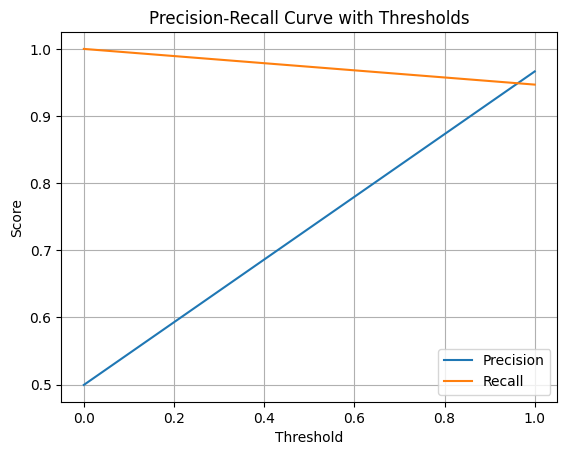

In [129]:
# Plot precision-recall curve with thresholds
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve with Thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [130]:
# Find threshold where recall equals precision or is closest to it
idx = np.argmin(np.abs(precision[:-1] - recall[:-1]))
equal_threshold = thresholds[idx]
print("Threshold where recall equals precision:", equal_threshold)

Threshold where recall equals precision: 1.0


In [ ]:
# Load the trained model
model = Model(embedding_size, lstm_hidden_size, hidden_layer_size,
              cnn_layer_size, class_layer)
model.load_state_dict(torch.load(model_save_path, map_location=DEVICE))
model.eval()
model.to(DEVICE)
model = model.to(DEVICE)

In [131]:
def preprocess(sentence: str, clean: Callable[[str], List[str]], word2vec: Callable[[str], torch.Tensor]) -> torch.Tensor:
    '''
    Preprocess a single sentence.
    :param sentence: The sentence to preprocess.
    :type sentence: str
    :param clean: The cleaning function.
    :type clean: Callable[[str], List[str]]
    :param word2vec: The word to vector function.
    :type word2vec: Callable[[str], torch.Tensor]
    :return: The preprocessed sentence.
    :rtype: torch.Tensor
    '''
    # Tokenize the sentence into words and convert to embeddings
    words = clean(sentence)
    sentence_tokens = [word2vec(word) for word in words]

    # Convert to the required format for input to the model
    sentence_tensor = torch.stack(sentence_tokens).to(DEVICE)

    return sentence_tensor

In [132]:
# test
if isTrain:
    sentence = "I want to kill myself"
    sentence_tensor = preprocess(sentence, clean, glove)
    print(sentence_tensor.shape)

torch.Size([5, 300])


In [133]:
def suicidal_detection(sentence: str, model: nn.Module) -> Tuple[str, Dict[str, float]]:
    """
    Predict the class of the sentence using the model.

    Args:
        sentence (str): The sentence.
        model (nn.Module): The model.

    Returns:
        Tuple[str, Dict[str, float]]: The name of the class with the highest probability and a dictionary mapping class names to probabilities.
    """
    model.eval()

    # Preprocess the sentence to get the input data
    input_data = preprocess(sentence, clean, glove)

    with torch.no_grad():
        output = model(input_data.unsqueeze(0))

    probabilities = output
    print(probabilities)

    # Threshold probabilities at 0.5 to make binary predictions
    predicted_class = (probabilities > classification_threshold).float()

    # Map the class index to the class name
    predicted_class_name = reverse_label_mapping[int(predicted_class.item())]

    # Map the probabilities to the class names
    sui_prob = probabilities.tolist()[0][0]
    sui_prob = round((sui_prob * 100), 3)
    non_prob = 100 - sui_prob
    class_probabilities = {
        reverse_label_mapping[0]:  non_prob,
        reverse_label_mapping[1]:  sui_prob
        }

    return predicted_class_name, class_probabilities

In [136]:
random_num_test = 530
dialogue = ["Hello, how are you?", "I will kill my self", 'I am sad',
            "I'm good, thanks! How about you?", "I'm doing well, thank you.", ' '.join(dialogues_test_proccessed[random_num_test])]
for sentence in dialogue:
    predicted_class_name, class_probabilities = suicidal_detection(
        sentence, model)
    print(f"Sentence: {sentence}")
    print(f"Predicted class: {predicted_class_name}")
    print()
    print("Class probabilities:")
    for class_name, probability in class_probabilities.items():
        print(f"{class_name}: {probability}")
    print('----------------------------------------------')

print(reverse_label_mapping[labels_test[random_num_test]])

tensor([[0.0080]], device='cuda:0')
Sentence: Hello, how are you?
Predicted class: non-suicide

Class probabilities:
non-suicide: 99.199
suicide: 0.801
----------------------------------------------
tensor([[0.4296]], device='cuda:0')
Sentence: I will kill my self
Predicted class: suicide

Class probabilities:
non-suicide: 57.037
suicide: 42.963
----------------------------------------------
tensor([[0.0889]], device='cuda:0')
Sentence: I am sad
Predicted class: non-suicide

Class probabilities:
non-suicide: 91.113
suicide: 8.887
----------------------------------------------
tensor([[0.0259]], device='cuda:0')
Sentence: I'm good, thanks! How about you?
Predicted class: non-suicide

Class probabilities:
non-suicide: 97.413
suicide: 2.587
----------------------------------------------
tensor([[0.1286]], device='cuda:0')
Sentence: I'm doing well, thank you.
Predicted class: non-suicide

Class probabilities:
non-suicide: 87.142
suicide: 12.858
---------------------------------------------